In [2]:
import warnings
warnings.filterwarnings('ignore')

# find ROIs
hand-picked regions of interest based on the figure

![selected ROIs](./data/ROIs-annotated.png)

In [3]:
# setup brain plot
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot

fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
import pandas as pd

In [5]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

In [6]:
region_names[region_names.str.startswith('7Networks_LH_DorsAttn')]
data = pd.Series(region_names).str.startswith('7Networks_LH_DorsAttn_FEF_5')
# data = pd.Series(region_names)==('7Networks_LH_Default_PFC_4')
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='bwr')
# _ = p.build()

In [7]:
seeds = ['7Networks_LH_Default_PFC_19', '7Networks_RH_Default_PFCdPFCm_14', '7Networks_LH_Vis_33',
         '7Networks_RH_Default_PFCv_6', '7Networks_RH_Default_PFCdPFCm_15', '7Networks_LH_SomMot_57',
         '7Networks_RH_Limbic_TempPole_1', '7Networks_LH_Limbic_TempPole_9', '7Networks_RH_Vis_45',
         '7Networks_LH_Default_Temp_15', '7Networks_LH_Default_PFC_31', '7Networks_LH_Default_PFC_4',
         '7Networks_LH_DorsAttn_FEF_5']

let's take one as a sample seed ROI

# calculate correlation for seeds
for a seed ROI, calculate connectivity during epochs

In [8]:
EPOCHS = ['baseline', 'early', 'late']

In [9]:
# the list of subjects, removed erroneous ones
subjects = pd.read_csv('data/subjects.csv')
S = subjects.int_id

we are ignoring 'rest' epoch. all calculation on these subjects.

In [10]:
from scipy.stats import pearsonr
from tqdm import tqdm
tqdm.pandas()

In [11]:
# in data/ts/ we don't have cerebellum regions included. only 1012 regions.
def timeseries(subject, epoch): return pd.read_csv('data/ts/ts_'+str(subject)+'_'+epoch+'.csv')

In [12]:
list0 = []
for seed in tqdm(seeds):
    list1 = []
    for e in EPOCHS:
        list2 = []
        for subj in S:
            ts = timeseries(subj, e)
            seed_ts = ts[seed]
            # we neglect pvalue of whether r is significant
            r = [pearsonr(seed_ts, ts[idx])[0] for idx in ts]   # pearsonr()[0] is rvalue
            r = pd.DataFrame({'r': r}, index=ts.columns)
            r.rename_axis('region', inplace=True)
            r = pd.concat([r], keys=[subj], names=['subject'])
            list2.append(r)
        r = pd.concat(list2, 0)
        r = pd.concat([r], keys=[e], names=['epoch'])   # adds epoch as lower level index
        list1.append(r)

    dfr = pd.concat(list1, 0)
    dfr = pd.concat([dfr], keys=[seed], names=['seed_region'])
    list0.append(dfr)

dfr = pd.concat(list0, 0)

100%|██████████| 13/13 [03:20<00:00, 15.40s/it]


# average over subjects
average seed connectivity over all subjects during each epoch.

In [13]:
dfr_mean = dfr.groupby(level=[0, 1, 3]).mean()
dfr_mean

r
seed_region                 epoch    region                            
7Networks_LH_Default_PFC_19 baseline 7Networks_LH_Cont_Cing_1  0.055564
                                     7Networks_LH_Cont_Cing_2 -0.045475
                                     7Networks_LH_Cont_Cing_3 -0.076467
                                     7Networks_LH_Cont_Cing_4 -0.031488
                                     7Networks_LH_Cont_Cing_5  0.094507
...                                                                 ...
7Networks_RH_Vis_45         late     Right Caudate             0.044653
                                     Right Hippocampus         0.033308
                                     Right Pallidum            0.001949
                                     Right Putamen            -0.000086
                                     Right Thalamus            0.099872

[39468 rows x 1 columns]

plot mean connectivity of one seed during one epoch

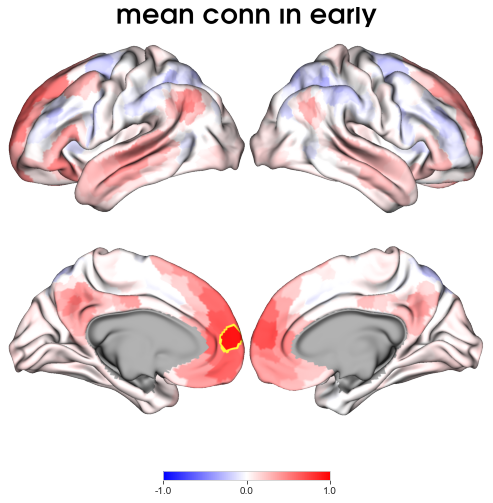

In [14]:
seed = seeds[0]
e = 'early'

data = dfr_mean.loc[seed, e]
data = data.loc[pd.Series(region_names)]['r']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 800),
         label_text={'top': ['mean conn in '+e]})
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1, 1))
# seed region outlined
data = map_to_labels(pd.Series(region_names)==seed, vertices, mask=(vertices != 0))
p.add_layer(data, cbar=False, as_outline=True)
_ = p.build()

# shift in seed connectivity
using pairwise t-tests between epochs, we can calculate statistical diff for seed region-region link.

In [22]:
import pingouin as pg

In [75]:
def ttest_epochs(df):
    df.index = df.index.droplevel([0,1])
    df = df.unstack(0)
    df.columns = df.columns.droplevel(0)
    b2e = pg.ttest(df['early'], df['baseline'], paired=True, alternative='greater').loc['T-test']
    e2l = pg.ttest(df['late'], df['early'], paired=True, alternative='greater').loc['T-test']
    return pd.Series([b2e['T'], b2e['p-val'], e2l['T'], e2l['p-val']], index=['b2e_t', 'b2e_p', 'e2l_t', 'e2l_p'])

In [72]:
dfr = dfr.round(4)

In [76]:
dfpairs = dfr.reorder_levels([0,3,1,2]).groupby(level=[0,1]).apply(ttest_epochs)

In [79]:
def plot_seed_shift(seed, masked=False, save=False):
    for pair in ['b2e', 'e2l']:
        t, pvalue = pair+'_t', pair+'_p'
        data = dfpairs.loc[seed].loc[region_names] # sort for plotting
        if masked:  data = data.apply(lambda row: row[t] if row[pvalue]<.05 else False, axis=1)
        else: data = data[t]
        data = map_to_labels(data, vertices, mask=(vertices != 0))
        plot = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), label_text=[seed[10:]+'__'+pair])
        plot.add_layer(data, cbar=True, cmap='bwr', color_range=(-4, 4))
        data1 = map_to_labels(region_names==seed, vertices, mask=(vertices != 0))
        plot.add_layer(data1, cbar=False, as_outline=True)  # seed region outlined
        fig = plot.build()
        if save:    fig.savefig('plots/seed/' + seed[10:] +
                                '__' + pair + '__' +
                                ('masked' if masked else 'notMasked') + '.png')

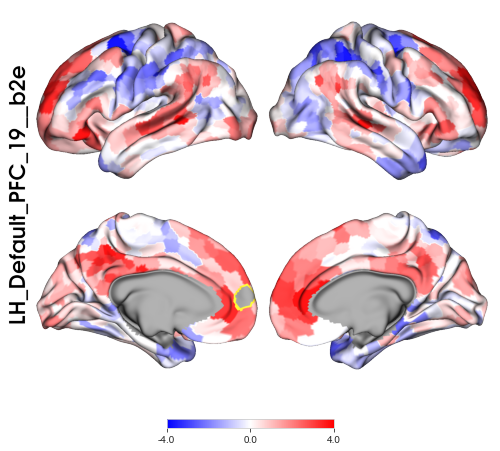

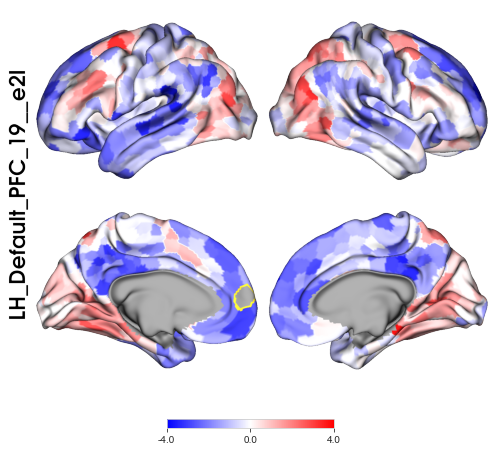

In [80]:
plot_seed_shift('7Networks_LH_Default_PFC_19', save=False)

In [83]:
# [plot_seed_shift(s,masked=m,save=True)
#  for s in seeds
#  for m in [True, False]]

appendix: the problem with reading t tests results

In [270]:
import seaborn

paired t tests early, baseline: 1.7032962922021126
one sample early minus baseline: 1.7032962922021126
both showing the shift from baseline to early (b2e)


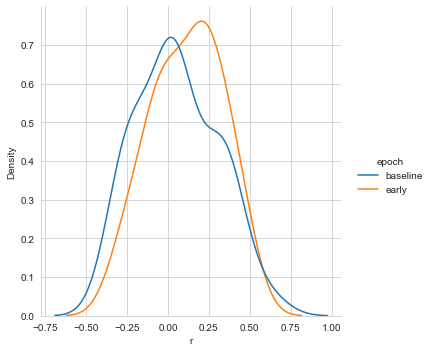

In [271]:
# how to interpret pingouin
d = dfr.reorder_levels([0,3,1,2])
d = d.loc['7Networks_LH_Default_PFC_19','7Networks_LH_Cont_Cing_1']
seaborn.displot(d.iloc[:-36], x='r', hue='epoch', kind='kde')
d = d.unstack(0)
d = d['r']
print('paired t tests early, baseline:', pg.ttest(d['early'], d['baseline'],
         alternative='greater', paired=True).loc['T-test', 'T'])    # if paired=False, result is pairwise_ttests
d['b2e'] = d.early - d.baseline
print('one sample early minus baseline:', pg.ttest(d.b2e, 0, alternative='greater').loc['T-test', 'T'])
print('both showing the shift from baseline to early (b2e)')